# Building Detection with Deep Learning MLP model - Taichung case study

Building detection in satellite imagery is crucial in city management. Buildings are one of the key pieces of information related to population and cities, and are fundamental to urban planning and spatial policy making. This project adopts a Deep Learning - Multilayer perceptron(MLP) model to detect Building shapes from Landsat satellite data.

In [1]:
# Load libraries
#GIS RS
from pyrsgis import raster   #! pip install pyrsgis
from pyrsgis.convert import changeDimension

import rasterio
from rasterio.mask import mask
import geopandas as gpd
from shapely.geometry import mapping
from rasterio.plot import show

#Basic
import os 
import numpy as np
from pandas import read_csv
from pandas import set_option
from pandas.plotting import scatter_matrix
from matplotlib import pyplot

#AI
from tensorflow import keras
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.model_selection import KFold
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import classification_report
from sklearn.metrics import confusion_matrix
from sklearn.metrics import accuracy_score
from sklearn.pipeline import Pipeline
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis
from sklearn.naive_bayes import GaussianNB
from sklearn.svm import SVC
from sklearn.ensemble import AdaBoostClassifier
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.ensemble import ExtraTreesClassifier
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix, precision_score, recall_score

%matplotlib inline

In [2]:
#from google.colab import drive
#import pandas as pd
#drive.mount('/content/gdrive') # 此處需要登入google帳號
# 獲取授權碼之後輸入即可連動雲端硬碟

In [3]:
# Change the directory
os.chdir(r"E:\Git AIEO\Data\Taichung 2021 Landsat")

## 1. Assign file

In [4]:
# Assign file names
feature_data = r"feature.tif"
label_data = r"label.tif"
predict_data = r"predic2021_2t.tif"

Text(0.5, 1.0, 'Predict (zoom out)')

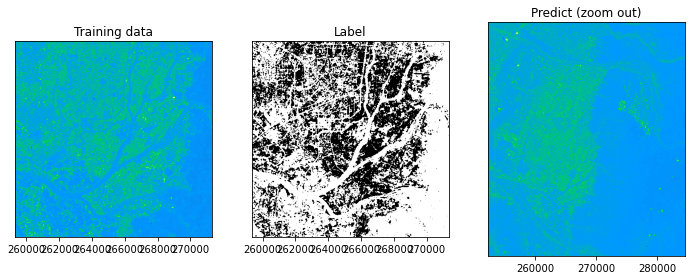

In [5]:
from rasterio.plot import show
import matplotlib.pyplot as plt
%matplotlib inline

# Create 3 plots next to each other
fig, (ax1, ax2, ax3) = plt.subplots(ncols=3, nrows=1, figsize=(12, 6))

a = rasterio.open(feature_data)
b = rasterio.open(label_data)
c = rasterio.open(predict_data)

# Plot first four files
show((a, 1,), cmap='terrain',  ax=ax1)
show((b, 1),  cmap='Greys', ax=ax2)
show((c, 1), cmap='terrain',  ax=ax3)

# Do not show y-ticks values in last three axis
for ax in [ax1, ax2, ax3]:
    ax.yaxis.set_visible(False)

    # Add a title
ax1.set_title('Training data')
ax2.set_title('Label')
ax3.set_title('Predict (zoom out)') 

# 2. Reshape
Reshape the array to single dimensional array

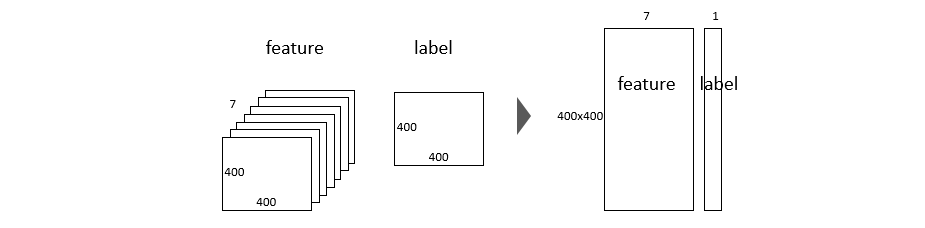

In [6]:
# Read the rasters as array
ds1, features = raster.read(feature_data, bands='all')
ds2, label = raster.read(label_data, bands=1)
ds3, predict_data = raster.read(predict_data, bands='all')

In [7]:
# Print the size of the arrays
print("features image shape: ", features.shape)
print("label shape: ", label.shape)
print("predict_data shape: ", predict_data.shape)

features image shape:  (7, 400, 400)
label shape:  (400, 400)
predict_data shape:  (7, 1275, 1075)


In [8]:
# Clean the labelled data to replace NoData values by zero
label = (label == 0).astype(int)

In [9]:
# Reshape the array to single dimensional array
features = changeDimension(features)
label = changeDimension (label)
predict_data = changeDimension(predict_data)
nBands = features.shape[1]

The "changeDimension()" function has moved to "array_to_table()" and will be deprecated in future versions. Please check the pyrsgis documentation at https://pyrsgis.readthedocs.io/en/master/ for more details.
The "changeDimension()" function has moved to "array_to_table()" and will be deprecated in future versions. Please check the pyrsgis documentation at https://pyrsgis.readthedocs.io/en/master/ for more details.
The "changeDimension()" function has moved to "array_to_table()" and will be deprecated in future versions. Please check the pyrsgis documentation at https://pyrsgis.readthedocs.io/en/master/ for more details.


In [10]:
print("Reshape features shape: ", features.shape)
print("Reshape label shape: ", label.shape)
print("Reshape Predicted_data image shape: ", predict_data.shape)

Reshape features shape:  (160000, 7)
Reshape label shape:  (160000,)
Reshape Predicted_data image shape:  (1370625, 7)


In [11]:
# If you want  to check the data structure
#np.set_printoptions(threshold=np.inf)
#features

## 3. Validation Dataset

In [12]:
# Split testing and training datasets
xTrain, xTest, yTrain, yTest = train_test_split(features, label, test_size=0.4, random_state=42)

In [13]:
print(xTrain.shape)
print(yTrain.shape)

(96000, 7)
(96000,)


In [14]:
print(xTest.shape)
print(yTest.shape)

(64000, 7)
(64000,)


## 4. Normalise
### xTrain,yTrain,xTest,yTest --> Normalise by maximum 

In [15]:
print('Values in input features, min: %d & max: %d' % (xTrain.min(), xTrain.max()))
print('Values in input features, min: %d & max: %d' % (xTest.min(), xTest.max()))
print('Values in input features, min: %d & max: %d' % (predict_data.min(), predict_data.max()))

Values in input features, min: 1044 & max: 57434
Values in input features, min: 3111 & max: 55980
Values in input features, min: 0 & max: 58435


In [16]:
# Normalise the data
xTrain = xTrain / 58435.0
xTest = xTest / 58435.0
predicted_data = predict_data / 58435.0

In [17]:
print('Normalise Values in input features, min: %d & max: %d' % (xTrain.min(), xTrain.max()))
print('Normalise Values in input features, min: %d & max: %d' % (xTest.min(), xTest.max()))
print('Normalise Values in input features, min: %d & max: %d' % (predicted_data.min(), predicted_data.max()))

Normalise Values in input features, min: 0 & max: 0
Normalise Values in input features, min: 0 & max: 0
Normalise Values in input features, min: 0 & max: 1


In [18]:
# Reshape the data
xTrain = xTrain.reshape((xTrain.shape[0], 1, xTrain.shape[1]))
xTest = xTest.reshape((xTest.shape[0], 1, xTest.shape[1]))
predict_data = predicted_data.reshape((predicted_data.shape[0], 1, predicted_data.shape[1]))

In [19]:
# Print the shape of reshaped data
print(xTrain.shape, xTest.shape, predict_data.shape)

(96000, 1, 7) (64000, 1, 7) (1370625, 1, 7)


In [20]:
print(yTrain.shape, yTest.shape)

(96000,) (64000,)


# 5.MODEL

In order to find the best model for building detection. Here I was turning the hyperparameters. Including model size(16,4,12), Adding weight regularization and Adding dropout.

### Model 1 (Basic, Layer=16)

In [21]:
from tensorflow.keras import models
from tensorflow.keras import layers

# Define the parameters of the model
model = keras.Sequential([
    keras.layers.Flatten(input_shape=(1, nBands)),
    keras.layers.Dense(16, activation='relu'),       #hidden layer
    keras.layers.Dense(16, activation='relu'),       #hidden layer
    keras.layers.Dense(2, activation='softmax')])   #最後有幾種，原本sigmoid

In [22]:
# Define the accuracy metrics and parameters
#不能用binary_crossentropy rmsprop

model.compile(optimizer="adam", loss="sparse_categorical_crossentropy", metrics=["accuracy"])
 

In [23]:
# Run the model
#model.fit(xTrain, yTrain, epochs=10)
history = model.fit(xTrain,
                    yTrain,
                    epochs=50,
                    batch_size=512,
                    validation_data=(xTest, yTest))

Epoch 1/50
188/188 [==============================] - 1s 2ms/step - loss: 0.6159 - accuracy: 0.7003 - val_loss: 0.4731 - val_accuracy: 0.9425
Epoch 2/50
188/188 [==============================] - 0s 1ms/step - loss: 0.2956 - accuracy: 0.9508 - val_loss: 0.1825 - val_accuracy: 0.9577
Epoch 3/50
188/188 [==============================] - 0s 1ms/step - loss: 0.1446 - accuracy: 0.9618 - val_loss: 0.1166 - val_accuracy: 0.9675
Epoch 4/50
188/188 [==============================] - 0s 1ms/step - loss: 0.1013 - accuracy: 0.9705 - val_loss: 0.0885 - val_accuracy: 0.9745
Epoch 5/50
188/188 [==============================] - 0s 1ms/step - loss: 0.0792 - accuracy: 0.9772 - val_loss: 0.0709 - val_accuracy: 0.9797
Epoch 6/50
188/188 [==============================] - 0s 1ms/step - loss: 0.0656 - accuracy: 0.9815 - val_loss: 0.0597 - val_accuracy: 0.9840
Epoch 7/50
188/188 [==============================] - 0s 1ms/step - loss: 0.0557 - accuracy: 0.9855 - val_loss: 0.0518 - val_accuracy: 0.9868
Epoch 

In [24]:
history_dict = history.history
history_dict.keys()

dict_keys(['loss', 'accuracy', 'val_loss', 'val_accuracy'])

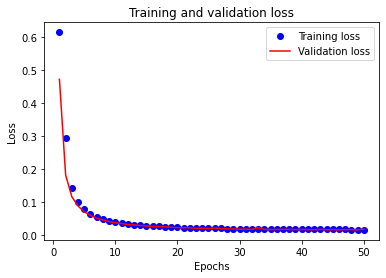

In [25]:
import matplotlib.pyplot as plt

acc = history.history['accuracy']
val_acc = history.history['val_accuracy']
loss = history.history['loss']
val_loss = history.history['val_loss']

epochs = range(1, len(acc) + 1)

# "bo" is for "blue dot"
plt.plot(epochs, loss, 'bo', label='Training loss')
# b is for "solid blue line"
plt.plot(epochs, val_loss, 'r', label='Validation loss')
plt.title('Training and validation loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()

plt.show()

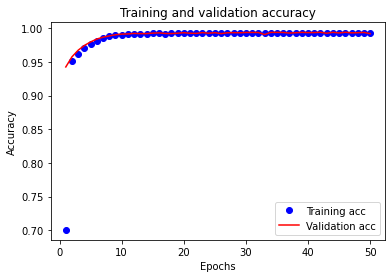

In [26]:
plt.clf()   # clear figure
acc_values = history_dict['accuracy']
val_acc_values = history_dict['val_accuracy']

plt.plot(epochs, acc, 'bo', label='Training acc')
plt.plot(epochs, val_acc, 'r', label='Validation acc')
plt.title('Training and validation accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()

plt.show()

### We can evaluate our results

In [27]:
#x_train
results = model.evaluate(xTrain, yTrain)

3000/3000 [==============================] - 2s 723us/step - loss: 0.0184 - accuracy: 0.9921


In [28]:
#x_test
results = model.evaluate(xTest, yTest)

2000/2000 [==============================] - 1s 727us/step - loss: 0.0183 - accuracy: 0.9920


-------------

## Model 2 (layers = 4)

In [29]:
# Define the parameters of the model
model2 = keras.Sequential([
    keras.layers.Flatten(input_shape=(1, nBands)),  #
    keras.layers.Dense(4, activation='relu'),       #hidden layer
    keras.layers.Dense(4, activation='relu'),
    keras.layers.Dense(2, activation='softmax')])   #最後有幾種

In [30]:
# Define the accuracy metrics and parameters
model2.compile(optimizer="adam", loss="sparse_categorical_crossentropy", metrics=["accuracy"])


In [31]:
# Run the model
history2 = model2.fit(xTrain,
                    yTrain,
                    epochs=50,
                    batch_size=512,
                    validation_data=(xTest, yTest))

Epoch 1/50
188/188 [==============================] - 0s 1ms/step - loss: 0.6722 - accuracy: 0.5943 - val_loss: 0.6390 - val_accuracy: 0.5984
Epoch 2/50
188/188 [==============================] - 0s 1ms/step - loss: 0.5610 - accuracy: 0.7361 - val_loss: 0.4513 - val_accuracy: 0.9291
Epoch 3/50
188/188 [==============================] - 0s 1ms/step - loss: 0.3520 - accuracy: 0.9382 - val_loss: 0.2706 - val_accuracy: 0.9465
Epoch 4/50
188/188 [==============================] - 0s 992us/step - loss: 0.2273 - accuracy: 0.9502 - val_loss: 0.1907 - val_accuracy: 0.9539
Epoch 5/50
188/188 [==============================] - 0s 1ms/step - loss: 0.1696 - accuracy: 0.9569 - val_loss: 0.1498 - val_accuracy: 0.9598
Epoch 6/50
188/188 [==============================] - 0s 1ms/step - loss: 0.1372 - accuracy: 0.9623 - val_loss: 0.1244 - val_accuracy: 0.9648
Epoch 7/50
188/188 [==============================] - 0s 987us/step - loss: 0.1159 - accuracy: 0.9664 - val_loss: 0.1069 - val_accuracy: 0.9685
Ep

In [32]:
history_dict2 = history2.history
history_dict2.keys()

dict_keys(['loss', 'accuracy', 'val_loss', 'val_accuracy'])

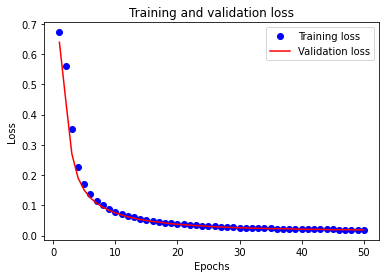

In [33]:
import matplotlib.pyplot as plt

acc = history2.history['accuracy']
val_acc = history2.history['val_accuracy']
loss = history2.history['loss']
val_loss = history2.history['val_loss']

epochs = range(1, len(acc) + 1)

# "bo" is for "blue dot"
plt.plot(epochs, loss, 'bo', label='Training loss')
# b is for "solid blue line"
plt.plot(epochs, val_loss, 'r', label='Validation loss')
plt.title('Training and validation loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()

plt.show()

### Compare Model 1 with Model 2

In [34]:
epochs = range(1, 51)
model_1_loss = history.history['val_loss']
model_2_loss = history2.history['val_loss']

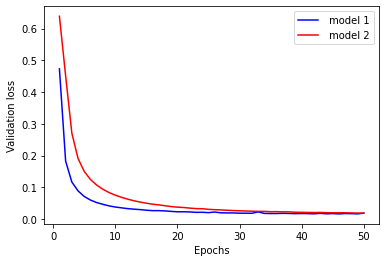

In [35]:
import matplotlib.pyplot as plt
%matplotlib inline 

# b+ is for "blue cross"
plt.plot(epochs, model_1_loss, 'b', label=' model 1')
# "bo" is for "blue dot"
plt.plot(epochs, model_2_loss, 'r', label=' model 2')
plt.xlabel('Epochs')
plt.ylabel('Validation loss')
plt.legend()

plt.show()

(上去是代表overfitting?) Smaller model loss score 下降比較慢

## MODEL 3 (Adding weight regularization)

In [36]:
# Define the parameters of the model
from tensorflow.keras import regularizers

model3 = keras.Sequential([
    keras.layers.Flatten(input_shape=(1, nBands)),   
    keras.layers.Dense(16, kernel_regularizer=regularizers.l2(0.001),
                          activation='relu'),       #hidden layer    
    keras.layers.Dense(16, kernel_regularizer=regularizers.l2(0.001),
                          activation='relu'),  
    keras.layers.Dense(2, activation='softmax')])   #最後有幾種


In [37]:
# Define the accuracy metrics and parameters
model3.compile(optimizer="adam", loss="sparse_categorical_crossentropy", metrics=["accuracy"])

In [38]:
# Run the model
history3 = model3.fit(xTrain,
                    yTrain,
                    epochs=50,
                    batch_size=512,
                    validation_data=(xTest, yTest))

Epoch 1/50
188/188 [==============================] - 1s 1ms/step - loss: 0.6225 - accuracy: 0.6978 - val_loss: 0.4699 - val_accuracy: 0.9018
Epoch 2/50
188/188 [==============================] - 0s 1ms/step - loss: 0.3209 - accuracy: 0.9574 - val_loss: 0.2237 - val_accuracy: 0.9679
Epoch 3/50
188/188 [==============================] - 0s 1ms/step - loss: 0.1880 - accuracy: 0.9701 - val_loss: 0.1619 - val_accuracy: 0.9723
Epoch 4/50
188/188 [==============================] - 0s 1ms/step - loss: 0.1477 - accuracy: 0.9755 - val_loss: 0.1359 - val_accuracy: 0.9778
Epoch 5/50
188/188 [==============================] - 0s 1ms/step - loss: 0.1281 - accuracy: 0.9797 - val_loss: 0.1210 - val_accuracy: 0.9820
Epoch 6/50
188/188 [==============================] - 0s 1ms/step - loss: 0.1161 - accuracy: 0.9831 - val_loss: 0.1115 - val_accuracy: 0.9850
Epoch 7/50
188/188 [==============================] - 0s 1ms/step - loss: 0.1079 - accuracy: 0.9858 - val_loss: 0.1043 - val_accuracy: 0.9875
Epoch 

In [39]:
#epochs = range(1, 51)

model_3_loss = history3.history['val_loss']

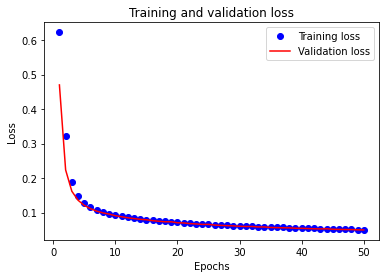

In [40]:
import matplotlib.pyplot as plt

acc = history3.history['accuracy']
val_acc = history3.history['val_accuracy']
loss = history3.history['loss']
val_loss = history3.history['val_loss']

epochs = range(1, len(acc) + 1)

# "bo" is for "blue dot"
plt.plot(epochs, loss, 'bo', label='Training loss')
# b is for "solid blue line"
plt.plot(epochs, val_loss, 'r', label='Validation loss')
plt.title('Training and validation loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()

plt.show()

## MODEL 4 (Adding dropou)


In [41]:
from tensorflow.keras import regularizers

# L1 regularization
regularizers.l1(0.001)

# L1 and L2 regularization at the same time
regularizers.l1_l2(l1=0.001, l2=0.001)

In [42]:
# Define the parameters of the model
model4 = keras.Sequential([
    keras.layers.Flatten(input_shape=(1, nBands)),   
    keras.layers.Dense(16, kernel_regularizer=regularizers.l2(0.001),
                          activation='relu'),
    keras.layers.Dropout(0.2),
    
    keras.layers.Dense(16, kernel_regularizer=regularizers.l2(0.001),
                          activation='relu'),  
    keras.layers.Dropout(0.2),
    
    keras.layers.Dense(2, activation='softmax')])  


In [43]:
# Define the accuracy metrics and parameters
model4.compile(optimizer="adam", loss="sparse_categorical_crossentropy", metrics=["accuracy"])

#不能用binary_crossentropy rmsprop

In [44]:
# Run the model
history4 = model4.fit(xTrain,
                    yTrain,
                    epochs=50,
                    batch_size=512,
                    validation_data=(xTest, yTest))

Epoch 1/50
188/188 [==============================] - 1s 2ms/step - loss: 0.6315 - accuracy: 0.7012 - val_loss: 0.4595 - val_accuracy: 0.9419
Epoch 2/50
188/188 [==============================] - 0s 1ms/step - loss: 0.3387 - accuracy: 0.8943 - val_loss: 0.2133 - val_accuracy: 0.9565
Epoch 3/50
188/188 [==============================] - 0s 2ms/step - loss: 0.2155 - accuracy: 0.9366 - val_loss: 0.1598 - val_accuracy: 0.9661
Epoch 4/50
188/188 [==============================] - 0s 2ms/step - loss: 0.1739 - accuracy: 0.9527 - val_loss: 0.1355 - val_accuracy: 0.9741
Epoch 5/50
188/188 [==============================] - 0s 2ms/step - loss: 0.1507 - accuracy: 0.9624 - val_loss: 0.1220 - val_accuracy: 0.9784
Epoch 6/50
188/188 [==============================] - 0s 1ms/step - loss: 0.1362 - accuracy: 0.9680 - val_loss: 0.1108 - val_accuracy: 0.9840
Epoch 7/50
188/188 [==============================] - 0s 2ms/step - loss: 0.1262 - accuracy: 0.9719 - val_loss: 0.1033 - val_accuracy: 0.9868
Epoch 

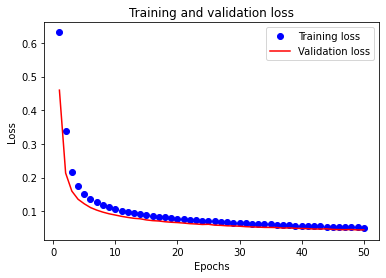

In [45]:
import matplotlib.pyplot as plt

acc = history4.history['accuracy']
val_acc = history4.history['val_accuracy']
loss = history4.history['loss']
val_loss = history4.history['val_loss']

epochs = range(1, len(acc) + 1)

# "bo" is for "blue dot"
plt.plot(epochs, loss, 'bo', label='Training loss')
# b is for "solid blue line"
plt.plot(epochs, val_loss, 'r', label='Validation loss')
plt.title('Training and validation loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()

plt.show()

## Comprehensive Evaluation Model 1~4

In [46]:
results1 = model.evaluate(xTest, yTest)  #16layers
results2 = model2.evaluate(xTest, yTest) #4layers
results3 = model3.evaluate(xTest, yTest) #12layers Adding weight regularization
results4 = model4.evaluate(xTest, yTest)  #Adding weight regularization & dropou

2000/2000 [==============================] - 1s 710us/step - loss: 0.0447 - accuracy: 0.9929


In [47]:
#epochs = range(1, 51)

model_4_loss = history4.history['val_loss']

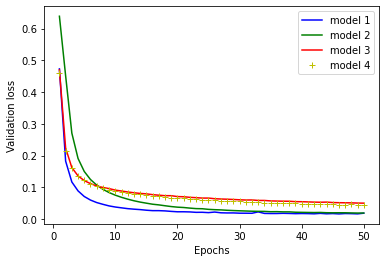

In [48]:
l2_model_val_loss = history3.history['val_loss']

plt.plot(epochs, model_1_loss, 'b', label='model 1')
plt.plot(epochs, model_2_loss, 'g', label='model 2')
plt.plot(epochs, model_3_loss, 'r', label='model 3')
plt.plot(epochs, model_4_loss, 'y+', label='model 4')


plt.xlabel('Epochs')
plt.ylabel('Validation loss')
plt.legend()

plt.show()

# 6. Predict

xTrain,yTrain,xTest,yTest   predict_data

partial_x_train,partial_y_train
x_val,y_val

xTrain = xTrain.reshape((xTrain.shape[0], 1, xTrain.shape[1]))
xTest = xTest.reshape((xTest.shape[0], 1, xTest.shape[1]))
features_predict_image = features_predict_image.reshape((features_predict_image.shape[0], 1, features_predict_image.shape[1]))

In [49]:
#選定模型
fmodel = model4

In [50]:
# Predict for test data 
yTestPredicted = model.predict(xTest)
yTestPredicted = yTestPredicted[:,1]

In [51]:
# Calculate and display the error metrics
yTestPredicted = (yTestPredicted>0.5).astype(int)
cMatrix = confusion_matrix(yTest, yTestPredicted)
pScore = precision_score(yTest, yTestPredicted)
rScore = recall_score(yTest, yTestPredicted)

In [52]:
print("Confusion matrix: for 14 nodes\n", cMatrix)
print("\nP-Score: %.3f, R-Score: %.3f" % (pScore, rScore))  #R召回率均


Confusion matrix: for 14 nodes
 [[25267   444]
 [   67 38222]]

P-Score: 0.989, R-Score: 0.998


In [53]:
predicted = fmodel.predict(predict_data)
predicted = predicted[:,1]

In [54]:
# Predict new data and export the probability raster
prediction = np.reshape(predicted, (ds3.RasterYSize, ds3.RasterXSize))
outFile = 'TC_predicted_AOI_building_F_Model3.tif'
raster.export(prediction, ds3, filename=outFile, dtype='float')

## show

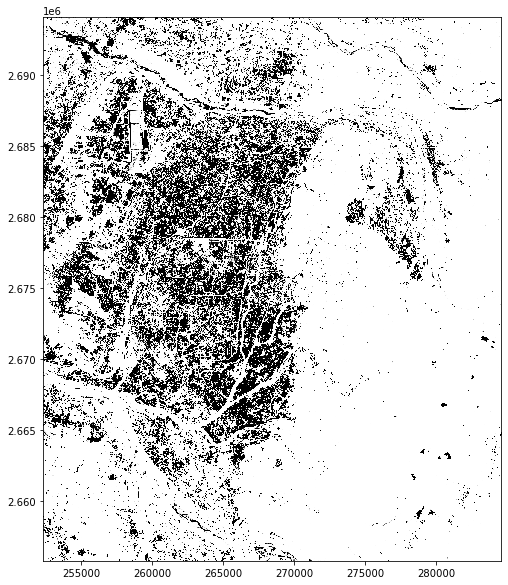

In [55]:
#import rasterio
#from rasterio.plot import show
pre = rasterio.open(outFile)
fig, ax = pyplot.subplots(1, figsize=(10, 10))

# Plot band 1
show((pre, 1), cmap='gist_gray', interpolation='none', ax=ax)
pyplot.show()